In [ ]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import osmnx as ox
import networkx
import numpy as np
from google.colab import drive
import os
from pyproj import CRS, Transformer
import traceback
from scipy.spatial import cKDTree

GEOHASH_PRECISION = 6
DEFAULT_SPEED_KPH = 30
MIN_SPEED_KPH = 5
fire_station_file_path = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
filtered_demand_zones_file_path = '/content/drive/MyDrive/Colab Notebooks/filtered_demand_zones.csv'
traffic_data_file_path = '/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv'
graphml_path = '/content/drive/MyDrive/Colab Notebooks/istanbul_yeni_drive_graph.graphml'

def load_traffic_data_from_file(csv_path):
    print(f"'{csv_path}' is loading (hourly average speeds)...")
    try:
        df = pd.read_csv(csv_path)
        df.columns = [str(col).strip().lower().replace(' ', '_') for col in df.columns]
        required_cols_lower = ['geohash', 'hour', 'average_speed']
        if not all(col in df.columns for col in required_cols_lower):
            print(f"WARNING: Expected columns ({required_cols_lower}) not found in the traffic CSV. Existing columns: {df.columns.tolist()}")
        print(f"'{csv_path}' loaded. {len(df)} traffic records found.")
        return df
    except FileNotFoundError: print(f"ERROR: Traffic data file not found: {csv_path}"); raise
    except Exception as e: print(f"ERROR: Problem while loading traffic data: {e}"); raise

def load_points_data(file_path, point_type="Fire Station", required_cols=('latitude', 'longitude'), name_col='station_name', geohash_col=None):
    print(f"'{file_path}' ({point_type} points) is loading...")
    try:
        df = pd.read_csv(file_path)
        original_columns = df.columns.tolist()
        df.columns = [str(col).strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
        common_rename_map = {
            'koordinat_y': 'longitude',
            'koordinat_x': 'latitude',
            'enlem': 'latitude',
            'boylam': 'longitude',
            'istasyon_adresi': 'address', 'i̇lçe': 'district', 'ilçe': 'district'
        }
        df.rename(columns=common_rename_map, inplace=True)
        name_col_lower = name_col.lower() if name_col else None
        if point_type == "Fire Station" and name_col_lower:
            if 'birim' in df.columns and name_col_lower == 'station_name':
                df.rename(columns={'birim': name_col_lower}, inplace=True)
            elif name_col_lower not in df.columns:
                print(f"WARNING: Expected name column '{name_col_lower}' not found in {point_type} data. Existing columns: {df.columns.tolist()}")
        final_required_cols = [str(col).lower() for col in required_cols]
        actual_cols_to_check_na = [col for col in final_required_cols if col in df.columns]
        if not actual_cols_to_check_na or not all(item in df.columns for item in ['latitude', 'longitude']):
            print(f"WARNING: Required latitude/longitude columns ({final_required_cols}) not found or missing in {point_type} data. Checked: {actual_cols_to_check_na}. Original columns: {original_columns}, Processed columns: {df.columns.tolist()}")
        else:
            original_len = len(df)
            df.dropna(subset=actual_cols_to_check_na, inplace=True)
            if len(df) < original_len: print(f"  {original_len - len(df)} rows dropped due to NA in {point_type} data (checked: {actual_cols_to_check_na}).")
        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            original_len_after_na = len(df)
            df.dropna(subset=['latitude', 'longitude'], inplace=True)
            if len(df) < original_len_after_na: print(f"  {original_len_after_na - len(df)} rows dropped due to invalid latitude/longitude in {point_type} data.")
        else: print(f"WARNING: 'latitude' or 'longitude' columns not found in {point_type} data (after standardization).")
        print(f"'{file_path}' loaded. {len(df)} valid {point_type} points found.")
        if len(df) > 0:
            print(f"  Sample {point_type} data (first row):")
            print(f"    Latitude: {df['latitude'].iloc[0]}, Longitude: {df['longitude'].iloc[0]}")
            if name_col_lower and name_col_lower in df.columns: print(f"    Name: {df[name_col_lower].iloc[0]}")
            if geohash_col and 'geohash' in df.columns and point_type == "Demand": print(f"    Geohash: {df['geohash'].iloc[0]}")
        return df
    except FileNotFoundError: print(f"ERROR: '{file_path}' not found."); raise
    except KeyError as ke: print(f"ERROR: '{file_path}' column error: {ke}. DF Columns: {df.columns.tolist() if 'df' in locals() else 'DF not loaded'}"); raise
    except Exception as e: print(f"ERROR: '{file_path}' general error: {e}"); raise

def load_osmnx_graph(graphml_path_local):
    print(f"Loading road network graph: {graphml_path_local}...")
    if not os.path.exists(graphml_path_local): raise FileNotFoundError(f"ERROR: GraphML file not found: {graphml_path_local}")
    try:
        G_loaded = ox.load_graphml(graphml_path_local)
        graph_crs_setting = G_loaded.graph.get('crs')
        if not (isinstance(graph_crs_setting, CRS) and graph_crs_setting.is_projected):
            print(f"Graph CRS ({graph_crs_setting}) not projected/unknown. Projecting to UTM...")
            G_proj = ox.project_graph(G_loaded)
        else:
            G_proj = G_loaded; print("Graph is already projected.")
        print(f"Graph loaded/processed: {len(G_proj.nodes)} nodes, {len(G_proj.edges)} edges. CRS: {G_proj.graph.get('crs')}")
        return G_proj
    except Exception as e: print(f"ERROR: Problem while loading GraphML: {e}"); raise

def get_edge_geohash(edge_geometry, source_crs_str, target_crs_str='epsg:4326', precision=GEOHASH_PRECISION):
    if not source_crs_str or not edge_geometry: return None
    try:
        centroid_source_crs = edge_geometry.centroid
        transformer = Transformer.from_crs(source_crs_str, target_crs_str, always_xy=True)
        lon_target_crs, lat_target_crs = transformer.transform(centroid_source_crs.x, centroid_source_crs.y)
        return pygeohash.encode(lat_target_crs, lon_target_crs, precision=precision)
    except Exception: return None

def update_graph_with_hourly_speeds_KDTREE(G_projected, hourly_traffic_data, target_hour_for_filter):
    print(f"Updating graph edges with KDTree for hour {target_hour_for_filter}...")
    G_updated = G_projected.copy()
    traffic_df_for_hour = hourly_traffic_data[hourly_traffic_data['hour'] == target_hour_for_filter]
    if traffic_df_for_hour.empty:
        print("WARNING: No traffic data for this hour, all edges will use default speed.")
        for u, v, k, data in G_updated.edges(keys=True, data=True):
            data['speed_kph'] = DEFAULT_SPEED_KPH
            edge_length_m = data.get('length', 0)
            data['travel_time'] = (edge_length_m / (DEFAULT_SPEED_KPH * 1000 / 3600)) if edge_length_m > 0 else float('inf')
        return G_updated
    traffic_points = traffic_df_for_hour[['latitude', 'longitude']].values
    traffic_speeds = traffic_df_for_hour['average_speed'].values
    speed_tree = cKDTree(traffic_points)
    graph_crs_str = G_projected.graph.get('crs')
    transformer_graph_to_wgs84 = Transformer.from_crs(graph_crs_str, 'epsg:4326', always_xy=True)
    edge_count = 0
    for u, v, k, data in G_updated.edges(keys=True, data=True):
        if 'geometry' in data:
            centroid = data['geometry'].centroid
            lon, lat = transformer_graph_to_wgs84.transform(centroid.x, centroid.y)
        else:
            node_u = G_updated.nodes[u]
            node_v = G_updated.nodes[v]
            lon = (node_u['x'] + node_v['x']) / 2
            lat = (node_u['y'] + node_v['y']) / 2
        dist, idx = speed_tree.query([[lat, lon]], k=1)
        current_speed_kph = traffic_speeds[idx[0]] if len(idx) > 0 else DEFAULT_SPEED_KPH
        data['speed_kph'] = max(current_speed_kph, MIN_SPEED_KPH)
        edge_length_m = data.get('length', 0)
        data['travel_time'] = (edge_length_m / (data['speed_kph'] * 1000 / 3600)) if edge_length_m > 0 and data['speed_kph'] > 0 else float('inf')
        edge_count += 1
        if edge_count <= 5:
            print(f"    Edge({u}-{v}): Speed={data['speed_kph']:.1f} km/h, travel_time={data['travel_time']:.1f} s")
    print(f"Total {edge_count} edges updated (KDTree used for nearest traffic point).")
    return G_updated

def calculate_single_travel_time(G_with_speeds, origin_lat_lon, destination_lat_lon, transformer_wgs84_to_graph_crs, origin_name="Origin", dest_name="Destination"):
    if not transformer_wgs84_to_graph_crs: return float('inf')
    try:
        origin_x_proj, origin_y_proj = transformer_wgs84_to_graph_crs.transform(origin_lat_lon[1], origin_lat_lon[0])
        dest_x_proj, dest_y_proj = transformer_wgs84_to_graph_crs.transform(destination_lat_lon[1], destination_lat_lon[0])
        origin_node = ox.nearest_nodes(G_with_speeds, X=origin_x_proj, Y=origin_y_proj)
        destination_node = ox.nearest_nodes(G_with_speeds, X=dest_x_proj, Y=dest_y_proj)
        if origin_node == destination_node: return 0.0
        return networkx.shortest_path_length(G_with_speeds, source=origin_node, target=destination_node, weight='travel_time')
    except networkx.NetworkXNoPath: return float('inf')
    except Exception as e:
        print(f"    ERROR: Error while calculating travel time ({origin_name} -> {dest_name}): {e}")
        traceback.print_exc()
        return float('inf')

if __name__ == '__main__':
    fire_station_df_main = load_points_data(fire_station_file_path, point_type="Fire Station", name_col='station_name', required_cols=('latitude', 'longitude', 'station_name'))
    demand_gdf_main = load_points_data(filtered_demand_zones_file_path, point_type="Demand", name_col=None, geohash_col='geohash', required_cols=('latitude', 'longitude', 'geohash'))
    traffic_df_main = load_traffic_data_from_file(traffic_data_file_path)
    G_main = load_osmnx_graph(graphml_path)
    if any(df is None or df.empty for df in [fire_station_df_main, demand_gdf_main, traffic_df_main]) or G_main is None:
        raise ValueError("One or more main data sources could not be loaded or are empty.")
    graph_crs_main_str = G_main.graph.get('crs')
    wgs84_to_graph_crs_transformer_main = Transformer.from_crs('epsg:4326', graph_crs_main_str, always_xy=True)
    temp_fire_station_nodes = []
    for idx, row in fire_station_df_main.iterrows():
        lat_val = row['latitude']
        lon_val = row['longitude']
        try:
            x_proj, y_proj = wgs84_to_graph_crs_transformer_main.transform(lon_val, lat_val)
            node_id = ox.nearest_nodes(G_main, X=x_proj, Y=y_proj)
            temp_fire_station_nodes.append(node_id)
        except Exception as e_nn_itf:
            temp_fire_station_nodes.append(pd.NA)
    fire_station_df_main['nearest_node'] = temp_fire_station_nodes
    fire_station_df_main.dropna(subset=['nearest_node'], inplace=True)
    fire_station_df_main['nearest_node'] = fire_station_df_main['nearest_node'].astype(np.int64)
    unique_station_nodes = fire_station_df_main['nearest_node'].unique()
    demand_lon = demand_gdf_main['longitude'].values
    demand_lat = demand_gdf_main['latitude'].values
    demand_x_proj, demand_y_proj = wgs84_to_graph_crs_transformer_main.transform(demand_lon, demand_lat)
    demand_gdf_main['nearest_node'] = ox.nearest_nodes(G_main, X=demand_x_proj, Y=demand_y_proj)
    fire_station_df_indexed = fire_station_df_main.reset_index(drop=True)
    demand_gdf_indexed = demand_gdf_main.reset_index(drop=True)
    num_stations = len(fire_station_df_indexed)
    num_demands = len(demand_gdf_indexed)
    station_names_for_index = fire_station_df_indexed['station_name'].tolist()
    demand_ids_for_columns = demand_gdf_indexed['geohash'].tolist()
    for hour in range(24):
        print(f"\n--- Creating Tij matrix for hour {hour} ---")
        G_hour = update_graph_with_hourly_speeds_KDTREE(G_main, traffic_df_main, hour)
        Tij_matrix = np.full((num_stations, num_demands), np.inf)
        calculation_successful_count = 0
        no_path_count = 0
        for i in range(num_stations):
            station_node = fire_station_df_indexed.loc[i, 'nearest_node']
            for j in range(num_demands):
                demand_node = demand_gdf_indexed.loc[j, 'nearest_node']
                if station_node == demand_node:
                    Tij_matrix[i, j] = 0
                    calculation_successful_count += 1
                    continue
                try:
                    travel_time_seconds = networkx.shortest_path_length(
                        G_hour, source=station_node, target=demand_node, weight='travel_time')
                    Tij_matrix[i, j] = travel_time_seconds
                    calculation_successful_count += 1
                except networkx.NetworkXNoPath:
                    Tij_matrix[i, j] = np.inf
                    no_path_count += 1
                except KeyError:
                    Tij_matrix[i, j] = np.inf
        print(f"Hour {hour}: Calculation finished. Successful: {calculation_successful_count}, No path: {no_path_count}")
        Tij_df_full = pd.DataFrame(Tij_matrix, index=station_names_for_index, columns=demand_ids_for_columns)
        Tij_df_full.to_csv(f'/content/drive/MyDrive/Colab Notebooks/matrix/Tij_matrix_hour_{hour}_yeni.csv', encoding='utf-8-sig')
        print(f"Tij matrix saved for hour {hour}.\n")


'/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv' (İtfaiye noktaları) yükleniyor...
'/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv' yüklendi. 11 geçerli İtfaiye noktası bulundu.
  Örnek İtfaiye verisi (ilk satır):
    Enlem: 41.048384752, Boylam: 28.990542219
    İsim: Beyoğlu İtfaiye İstasyonu
'/content/drive/MyDrive/Colab Notebooks/filtered_demand_zones.csv' (Talep noktaları) yükleniyor...
'/content/drive/MyDrive/Colab Notebooks/filtered_demand_zones.csv' yüklendi. 218 geçerli Talep noktası bulundu.
  Örnek Talep verisi (ilk satır):
    Enlem: 41.04217529296875, Boylam: 28.9874267578125
    Geohash: sxk97x
'/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv' yükleniyor (saatlik ortalama hızlar)...
'/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv' yüklendi. 5873 trafik kaydı bulundu.
Yol ağı grafiği yükleniyor: /content/drive/MyDrive/Colab Notebooks/istanbul_yeni_drive_graph.graphml...
Graf CRS (E

Seçilen talep ID'leri (ilk 10): ['sxkdhz', 'sxk9u4', 'sxkdk5', 'sxk9ee', 'sxk9ub', 'sxkdt0', 'sxkde3', 'sxkdh5', 'sxk9g3', 'sxk9s3']
Toplam seçili talep: 80


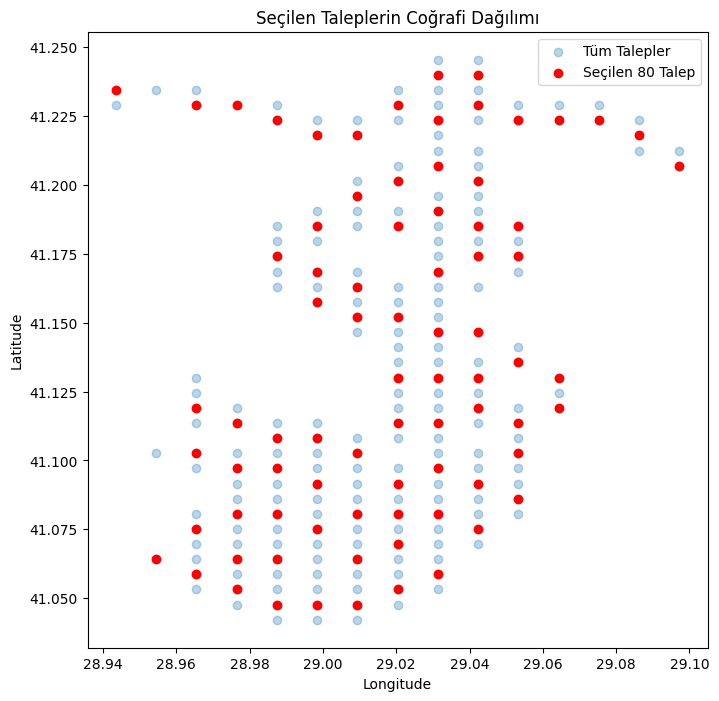

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

location_path = "/content/drive/MyDrive/Colab Notebooks/filtered_demand_zones.csv"

df = pd.read_csv(location_path)

target_demands = 80

coords = df[["LATITUDE", "LONGITUDE"]].values
k = min(target_demands, len(df))

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(coords)

chosen_demands = []
for cluster_id in range(k):
    cluster_points = df[df["cluster"] == cluster_id].copy()
    center = kmeans.cluster_centers_[cluster_id]
    cluster_points["dist"] = ((cluster_points[["LATITUDE", "LONGITUDE"]] - center) ** 2).sum(axis=1)
    chosen_demand = cluster_points.sort_values("dist").iloc[0]
    chosen_demands.append(chosen_demand)

chosen_df = pd.DataFrame(chosen_demands)

selected_demand_ids = chosen_df["GEOHASH"].tolist()
print("Selected demand IDs (first 10):", selected_demand_ids[:10])
print("Total selected demand:", len(selected_demand_ids))

plt.figure(figsize=(8,8))
plt.scatter(df["LONGITUDE"], df["LATITUDE"], alpha=0.3, label="All Demands")
plt.scatter(chosen_df["LONGITUDE"], chosen_df["LATITUDE"], color='red', label="Selected 80 Demands")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical Distribution of Selected Demands")
plt.legend()
plt.show()

chosen_df.to_csv("/content/drive/MyDrive/Colab Notebooks/matrix/selected_80_demand_zones.csv", index=False)


In [ ]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import osmnx as ox
import networkx
import numpy as np
from pyproj import CRS, Transformer
import traceback
from scipy.spatial import cKDTree
import os

GEOHASH_PRECISION = 6
DEFAULT_SPEED_KPH = 30
MIN_SPEED_KPH = 5
fire_station_file_path = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
selected_demand_zones_file_path = '/content/drive/MyDrive/Colab Notebooks/selected_80_demand_zones.csv'
traffic_data_file_path = '/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv'
graphml_path = '/content/drive/MyDrive/Colab Notebooks/istanbul_yeni_drive_graph.graphml'

def load_traffic_data_from_file(csv_path):
    print(f"'{csv_path}' is loading (hourly average speeds)...")
    try:
        df = pd.read_csv(csv_path)
        df.columns = [str(col).strip().lower().replace(' ', '_') for col in df.columns]
        required_cols_lower = ['geohash', 'hour', 'average_speed']
        if not all(col in df.columns for col in required_cols_lower):
            print(f"WARNING: Expected columns ({required_cols_lower}) not found in the traffic CSV. Existing columns: {df.columns.tolist()}")
        print(f"'{csv_path}' loaded. {len(df)} traffic records found.")
        return df
    except FileNotFoundError: print(f"ERROR: Traffic data file not found: {csv_path}"); raise
    except Exception as e: print(f"ERROR: Problem while loading traffic data: {e}"); raise

def load_points_data(file_path, point_type="Fire Station", required_cols=('latitude', 'longitude'), name_col='station_name', geohash_col=None):
    print(f"'{file_path}' ({point_type} points) is loading...")
    try:
        df = pd.read_csv(file_path)
        original_columns = df.columns.tolist()
        df.columns = [str(col).strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
        common_rename_map = {
            'koordinat_y': 'longitude',
            'koordinat_x': 'latitude',
            'enlem': 'latitude',
            'boylam': 'longitude',
            'istasyon_adresi': 'address', 'i̇lçe': 'district', 'ilçe': 'district'
        }
        df.rename(columns=common_rename_map, inplace=True)
        name_col_lower = name_col.lower() if name_col else None
        if point_type == "Fire Station" and name_col_lower:
            if 'birim' in df.columns and name_col_lower == 'station_name':
                df.rename(columns={'birim': name_col_lower}, inplace=True)
            elif name_col_lower not in df.columns:
                print(f"WARNING: Expected name column '{name_col_lower}' not found in {point_type} data. Existing columns: {df.columns.tolist()}")
        final_required_cols = [str(col).lower() for col in required_cols]
        actual_cols_to_check_na = [col for col in final_required_cols if col in df.columns]
        if not actual_cols_to_check_na or not all(item in df.columns for item in ['latitude', 'longitude']):
            print(f"WARNING: Required latitude/longitude columns ({final_required_cols}) not found or missing in {point_type} data. Checked: {actual_cols_to_check_na}. Original columns: {original_columns}, Processed columns: {df.columns.tolist()}")
        else:
            original_len = len(df)
            df.dropna(subset=actual_cols_to_check_na, inplace=True)
            if len(df) < original_len: print(f"  {original_len - len(df)} rows dropped due to NA in {point_type} data (checked: {actual_cols_to_check_na}).")
        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            original_len_after_na = len(df)
            df.dropna(subset=['latitude', 'longitude'], inplace=True)
            if len(df) < original_len_after_na: print(f"  {original_len_after_na - len(df)} rows dropped due to invalid latitude/longitude in {point_type} data.")
        else: print(f"WARNING: 'latitude' or 'longitude' columns not found in {point_type} data (after standardization).")
        print(f"'{file_path}' loaded. {len(df)} valid {point_type} points found.")
        if len(df) > 0:
            print(f"  Sample {point_type} data (first row):")
            print(f"    Latitude: {df['latitude'].iloc[0]}, Longitude: {df['longitude'].iloc[0]}")
            if name_col_lower and name_col_lower in df.columns: print(f"    Name: {df[name_col_lower].iloc[0]}")
            if geohash_col and 'geohash' in df.columns and point_type == "Demand": print(f"    Geohash: {df['geohash'].iloc[0]}")
        return df
    except FileNotFoundError: print(f"ERROR: '{file_path}' not found."); raise
    except KeyError as ke: print(f"ERROR: '{file_path}' column error: {ke}. DF Columns: {df.columns.tolist() if 'df' in locals() else 'DF not loaded'}"); raise
    except Exception as e: print(f"ERROR: '{file_path}' general error: {e}"); raise

def load_osmnx_graph(graphml_path_local):
    print(f"Loading road network graph: {graphml_path_local}...")
    if not os.path.exists(graphml_path_local): raise FileNotFoundError(f"ERROR: GraphML file not found: {graphml_path_local}")
    try:
        G_loaded = ox.load_graphml(graphml_path_local)
        graph_crs_setting = G_loaded.graph.get('crs')
        if not (isinstance(graph_crs_setting, CRS) and graph_crs_setting.is_projected):
            print(f"Graph CRS ({graph_crs_setting}) not projected/unknown. Projecting to UTM...")
            G_proj = ox.project_graph(G_loaded)
        else:
            G_proj = G_loaded; print("Graph is already projected.")
        print(f"Graph loaded/processed: {len(G_proj.nodes)} nodes, {len(G_proj.edges)} edges. CRS: {G_proj.graph.get('crs')}")
        return G_proj
    except Exception as e: print(f"ERROR: Problem while loading GraphML: {e}"); raise

def get_edge_geohash(edge_geometry, source_crs_str, target_crs_str='epsg:4326', precision=GEOHASH_PRECISION):
    if not source_crs_str or not edge_geometry: return None
    try:
        centroid_source_crs = edge_geometry.centroid
        transformer = Transformer.from_crs(source_crs_str, target_crs_str, always_xy=True)
        lon_target_crs, lat_target_crs = transformer.transform(centroid_source_crs.x, centroid_source_crs.y)
        return pygeohash.encode(lat_target_crs, lon_target_crs, precision=precision)
    except Exception: return None

def update_graph_with_hourly_speeds_KDTREE(G_projected, hourly_traffic_data, target_hour_for_filter):
    print(f"Updating graph edges with KDTree for hour {target_hour_for_filter}...")
    G_updated = G_projected.copy()
    traffic_df_for_hour = hourly_traffic_data[hourly_traffic_data['hour'] == target_hour_for_filter]
    if traffic_df_for_hour.empty:
        print("WARNING: No traffic data for this hour, all edges will use default speed.")
        for u, v, k, data in G_updated.edges(keys=True, data=True):
            data['speed_kph'] = DEFAULT_SPEED_KPH
            edge_length_m = data.get('length', 0)
            data['travel_time'] = (edge_length_m / (DEFAULT_SPEED_KPH * 1000 / 3600)) if edge_length_m > 0 else float('inf')
        return G_updated
    traffic_points = traffic_df_for_hour[['latitude', 'longitude']].values
    traffic_speeds = traffic_df_for_hour['average_speed'].values
    speed_tree = cKDTree(traffic_points)
    graph_crs_str = G_projected.graph.get('crs')
    transformer_graph_to_wgs84 = Transformer.from_crs(graph_crs_str, 'epsg:4326', always_xy=True)
    edge_count = 0
    for u, v, k, data in G_updated.edges(keys=True, data=True):
        if 'geometry' in data:
            centroid = data['geometry'].centroid
            lon, lat = transformer_graph_to_wgs84.transform(centroid.x, centroid.y)
        else:
            node_u = G_updated.nodes[u]
            node_v = G_updated.nodes[v]
            lon = (node_u['x'] + node_v['x']) / 2
            lat = (node_u['y'] + node_v['y']) / 2
        dist, idx = speed_tree.query([[lat, lon]], k=1)
        current_speed_kph = traffic_speeds[idx[0]] if len(idx) > 0 else DEFAULT_SPEED_KPH
        data['speed_kph'] = max(current_speed_kph, MIN_SPEED_KPH)
        edge_length_m = data.get('length', 0)
        data['travel_time'] = (edge_length_m / (data['speed_kph'] * 1000 / 3600)) if edge_length_m > 0 and data['speed_kph'] > 0 else float('inf')
        edge_count += 1
        if edge_count <= 5:
            print(f"    Edge({u}-{v}): Speed={data['speed_kph']:.1f} km/h, travel_time={data['travel_time']:.1f} s")
    print(f"Total {edge_count} edges updated (KDTree used for nearest traffic point).")
    return G_updated

def calculate_single_travel_time(G_with_speeds, origin_lat_lon, destination_lat_lon, transformer_wgs84_to_graph_crs, origin_name="Origin", dest_name="Destination"):
    if not transformer_wgs84_to_graph_crs: return float('inf')
    try:
        origin_x_proj, origin_y_proj = transformer_wgs84_to_graph_crs.transform(origin_lat_lon[1], origin_lat_lon[0])
        dest_x_proj, dest_y_proj = transformer_wgs84_to_graph_crs.transform(destination_lat_lon[1], destination_lat_lon[0])
        origin_node = ox.nearest_nodes(G_with_speeds, X=origin_x_proj, Y=origin_y_proj)
        destination_node = ox.nearest_nodes(G_with_speeds, X=dest_x_proj, Y=dest_y_proj)
        if origin_node == destination_node: return 0.0
        return networkx.shortest_path_length(G_with_speeds, source=origin_node, target=destination_node, weight='travel_time')
    except networkx.NetworkXNoPath: return float('inf')
    except Exception as e:
        print(f"    ERROR: Error while calculating travel time ({origin_name} -> {dest_name}): {e}")
        traceback.print_exc()
        return float('inf')

if __name__ == '__main__':
    fire_station_df_main = load_points_data(
        fire_station_file_path, point_type="Fire Station",
        name_col='station_name', required_cols=('latitude', 'longitude', 'station_name')
    )
    demand_gdf_main = load_points_data(
        selected_demand_zones_file_path,
        point_type="Demand", name_col=None,
        geohash_col='geohash', required_cols=('latitude', 'longitude', 'geohash')
    )
    traffic_df_main = load_traffic_data_from_file(traffic_data_file_path)
    G_main = load_osmnx_graph(graphml_path)
    if any(df is None or df.empty for df in [fire_station_df_main, demand_gdf_main, traffic_df_main]) or G_main is None:
        raise ValueError("One or more main data sources could not be loaded or are empty.")
    graph_crs_main_str = G_main.graph.get('crs')
    wgs84_to_graph_crs_transformer_main = Transformer.from_crs('epsg:4326', graph_crs_main_str, always_xy=True)
    temp_fire_station_nodes = []
    for idx, row in fire_station_df_main.iterrows():
        lat_val = row['latitude']
        lon_val = row['longitude']
        try:
            x_proj, y_proj = wgs84_to_graph_crs_transformer_main.transform(lon_val, lat_val)
            node_id = ox.nearest_nodes(G_main, X=x_proj, Y=y_proj)
            temp_fire_station_nodes.append(node_id)
        except Exception as e_nn_itf:
            temp_fire_station_nodes.append(pd.NA)
    fire_station_df_main['nearest_node'] = temp_fire_station_nodes
    fire_station_df_main.dropna(subset=['nearest_node'], inplace=True)
    fire_station_df_main['nearest_node'] = fire_station_df_main['nearest_node'].astype(np.int64)
    unique_station_nodes = fire_station_df_main['nearest_node'].unique()
    demand_lon = demand_gdf_main['longitude'].values
    demand_lat = demand_gdf_main['latitude'].values
    demand_x_proj, demand_y_proj = wgs84_to_graph_crs_transformer_main.transform(demand_lon, demand_lat)
    demand_gdf_main['nearest_node'] = ox.nearest_nodes(G_main, X=demand_x_proj, Y=demand_y_proj)
    fire_station_df_indexed = fire_station_df_main.reset_index(drop=True)
    demand_gdf_indexed = demand_gdf_main.reset_index(drop=True)
    num_stations = len(fire_station_df_indexed)
    num_demands = len(demand_gdf_indexed)
    station_names_for_index = fire_station_df_indexed['station_name'].tolist()
    demand_ids_for_columns = demand_gdf_indexed['geohash'].tolist()
    for hour in range(24):
        print(f"\n--- Creating Tij matrix for hour {hour} ---")
        G_hour = update_graph_with_hourly_speeds_KDTREE(G_main, traffic_df_main, hour)
        Tij_matrix = np.full((num_stations, num_demands), np.inf)
        calculation_successful_count = 0
        no_path_count = 0
        for i in range(num_stations):
            station_node = fire_station_df_indexed.loc[i, 'nearest_node']
            for j in range(num_demands):
                demand_node = demand_gdf_indexed.loc[j, 'nearest_node']
                if station_node == demand_node:
                    Tij_matrix[i, j] = 0
                    calculation_successful_count += 1
                    continue
                try:
                    travel_time_seconds = networkx.shortest_path_length(
                        G_hour, source=station_node, target=demand_node, weight='travel_time')
                    Tij_matrix[i, j] = travel_time_seconds
                    calculation_successful_count += 1
                except networkx.NetworkXNoPath:
                    Tij_matrix[i, j] = np.inf
                    no_path_count += 1
                except KeyError:
                    Tij_matrix[i, j] = np.inf
        print(f"Hour {hour}: Calculation finished. Successful: {calculation_successful_count}, No path: {no_path_count}")
        Tij_df_full = pd.DataFrame(Tij_matrix, index=station_names_for_index, columns=demand_ids_for_columns)
        Tij_df_full.to_csv(f'/content/drive/MyDrive/Colab Notebooks/matrix/filter_kmeans80_Tij_matrix_hour_{hour}_yeni.csv', encoding='utf-8-sig')
        print(f"Tij matrix saved for hour {hour}.\n")


'/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv' (İtfaiye noktaları) yükleniyor...
'/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv' yüklendi. 11 geçerli İtfaiye noktası bulundu.
  Örnek İtfaiye verisi (ilk satır):
    Enlem: 41.048384752, Boylam: 28.990542219
    İsim: Beyoğlu İtfaiye İstasyonu
'/content/drive/MyDrive/Colab Notebooks/selected_80_demand_zones.csv' (Talep noktaları) yükleniyor...
'/content/drive/MyDrive/Colab Notebooks/selected_80_demand_zones.csv' yüklendi. 80 geçerli Talep noktası bulundu.
  Örnek Talep verisi (ilk satır):
    Enlem: 41.17401123046875, Boylam: 29.0423583984375
    Geohash: sxkdhz
'/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv' yükleniyor (saatlik ortalama hızlar)...
'/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv' yüklendi. 5873 trafik kaydı bulundu.
Yol ağı grafiği yükleniyor: /content/drive/MyDrive/Colab Notebooks/istanbul_yeni_drive_graph.graphml...
Graf C

In [ ]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import osmnx as ox
import networkx
import numpy as np
from google.colab import drive
import os
from pyproj import CRS, Transformer
import traceback
from scipy.spatial import cKDTree

GEOHASH_PRECISION = 6
DEFAULT_SPEED_KPH = 30
MIN_SPEED_KPH = 5
fire_station_file_path = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
filtered_demand_zones_file_path = '/content/drive/MyDrive/Colab Notebooks/final_critical_demand_zones_80_for_success.csv'
traffic_data_file_path = '/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv'
graphml_path = '/content/drive/MyDrive/Colab Notebooks/istanbul_yeni_drive_graph.graphml'

def load_traffic_data_from_file(csv_path):
    print(f"'{csv_path}' is loading (hourly average speeds)...")
    try:
        df = pd.read_csv(csv_path)
        df.columns = [str(col).strip().lower().replace(' ', '_') for col in df.columns]
        required_cols_lower = ['geohash', 'hour', 'average_speed']
        if not all(col in df.columns for col in required_cols_lower):
            print(f"WARNING: Expected columns ({required_cols_lower}) not found in the traffic CSV. Existing columns: {df.columns.tolist()}")
        print(f"'{csv_path}' loaded. {len(df)} traffic records found.")
        return df
    except FileNotFoundError: print(f"ERROR: Traffic data file not found: {csv_path}"); raise
    except Exception as e: print(f"ERROR: Problem while loading traffic data: {e}"); raise

def load_points_data(file_path, point_type="Fire Station", required_cols=('latitude', 'longitude'), name_col='station_name', geohash_col=None):
    print(f"'{file_path}' ({point_type} points) is loading...")
    try:
        df = pd.read_csv(file_path)
        original_columns = df.columns.tolist()
        df.columns = [str(col).strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for col in df.columns]
        common_rename_map = {
            'koordinat_y': 'longitude',
            'koordinat_x': 'latitude',
            'enlem': 'latitude',
            'boylam': 'longitude',
            'istasyon_adresi': 'address', 'i̇lçe': 'district', 'ilçe': 'district'
        }
        df.rename(columns=common_rename_map, inplace=True)
        name_col_lower = name_col.lower() if name_col else None
        if point_type == "Fire Station" and name_col_lower:
            if 'birim' in df.columns and name_col_lower == 'station_name':
                df.rename(columns={'birim': name_col_lower}, inplace=True)
            elif name_col_lower not in df.columns:
                print(f"WARNING: Expected name column '{name_col_lower}' not found in {point_type} data. Existing columns: {df.columns.tolist()}")
        final_required_cols = [str(col).lower() for col in required_cols]
        actual_cols_to_check_na = [col for col in final_required_cols if col in df.columns]
        if not actual_cols_to_check_na or not all(item in df.columns for item in ['latitude', 'longitude']):
             print(f"WARNING: Required latitude/longitude columns ({final_required_cols}) not found or missing in {point_type} data. Checked: {actual_cols_to_check_na}. Original columns: {original_columns}, Processed columns: {df.columns.tolist()}")
        else:
            original_len = len(df)
            df.dropna(subset=actual_cols_to_check_na, inplace=True)
            if len(df) < original_len: print(f"  {original_len - len(df)} rows dropped due to NA in {point_type} data (checked: {actual_cols_to_check_na}).")
        if 'latitude' in df.columns and 'longitude' in df.columns:
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            original_len_after_na = len(df)
            df.dropna(subset=['latitude', 'longitude'], inplace=True)
            if len(df) < original_len_after_na: print(f"  {original_len_after_na - len(df)} rows dropped due to invalid latitude/longitude in {point_type} data.")
        else: print(f"WARNING: 'latitude' or 'longitude' columns not found in {point_type} data (after standardization).")
        print(f"'{file_path}' loaded. {len(df)} valid {point_type} points found.")
        if len(df) > 0:
            print(f"  Sample {point_type} data (first row):")
            print(f"    Latitude: {df['latitude'].iloc[0]}, Longitude: {df['longitude'].iloc[0]}")
            if name_col_lower and name_col_lower in df.columns: print(f"    Name: {df[name_col_lower].iloc[0]}")
            if geohash_col and 'geohash' in df.columns and point_type == "Demand": print(f"    Geohash: {df['geohash'].iloc[0]}")
        return df
    except FileNotFoundError: print(f"ERROR: '{file_path}' not found."); raise
    except KeyError as ke: print(f"ERROR: '{file_path}' column error: {ke}. DF Columns: {df.columns.tolist() if 'df' in locals() else 'DF not loaded'}"); raise
    except Exception as e: print(f"ERROR: '{file_path}' general error: {e}"); raise

def load_osmnx_graph(graphml_path_local):
    print(f"Loading road network graph: {graphml_path_local}...")
    if not os.path.exists(graphml_path_local): raise FileNotFoundError(f"ERROR: GraphML file not found: {graphml_path_local}")
    try:
        G_loaded = ox.load_graphml(graphml_path_local)
        graph_crs_setting = G_loaded.graph.get('crs')
        if not (isinstance(graph_crs_setting, CRS) and graph_crs_setting.is_projected):
            print(f"Graph CRS ({graph_crs_setting}) not projected/unknown. Projecting to UTM...")
            G_proj = ox.project_graph(G_loaded)
        else:
            G_proj = G_loaded; print("Graph is already projected.")
        print(f"Graph loaded/processed: {len(G_proj.nodes)} nodes, {len(G_proj.edges)} edges. CRS: {G_proj.graph.get('crs')}")
        return G_proj
    except Exception as e: print(f"ERROR: Problem while loading GraphML: {e}"); raise

def get_edge_geohash(edge_geometry, source_crs_str, target_crs_str='epsg:4326', precision=GEOHASH_PRECISION):
    if not source_crs_str or not edge_geometry: return None
    try:
        centroid_source_crs = edge_geometry.centroid
        transformer = Transformer.from_crs(source_crs_str, target_crs_str, always_xy=True)
        lon_target_crs, lat_target_crs = transformer.transform(centroid_source_crs.x, centroid_source_crs.y)
        return pygeohash.encode(lat_target_crs, lon_target_crs, precision=precision)
    except Exception: return None

def update_graph_with_hourly_speeds_KDTREE(G_projected, hourly_traffic_data, target_hour_for_filter):
    print(f"Updating graph edges with KDTree for hour {target_hour_for_filter}...")
    G_updated = G_projected.copy()
    traffic_df_for_hour = hourly_traffic_data[hourly_traffic_data['hour'] == target_hour_for_filter]
    if traffic_df_for_hour.empty:
        print("WARNING: No traffic data for this hour, all edges will use default speed.")
        for u, v, k, data in G_updated.edges(keys=True, data=True):
            data['speed_kph'] = DEFAULT_SPEED_KPH
            edge_length_m = data.get('length', 0)
            data['travel_time'] = (edge_length_m / (DEFAULT_SPEED_KPH * 1000 / 3600)) if edge_length_m > 0 else float('inf')
        return G_updated
    traffic_points = traffic_df_for_hour[['latitude', 'longitude']].values
    traffic_speeds = traffic_df_for_hour['average_speed'].values
    speed_tree = cKDTree(traffic_points)
    graph_crs_str = G_projected.graph.get('crs')
    transformer_graph_to_wgs84 = Transformer.from_crs(graph_crs_str, 'epsg:4326', always_xy=True)
    edge_count = 0
    for u, v, k, data in G_updated.edges(keys=True, data=True):
        if 'geometry' in data:
            centroid = data['geometry'].centroid
            lon, lat = transformer_graph_to_wgs84.transform(centroid.x, centroid.y)
        else:
            node_u = G_updated.nodes[u]
            node_v = G_updated.nodes[v]
            lon = (node_u['x'] + node_v['x']) / 2
            lat = (node_u['y'] + node_v['y']) / 2
        dist, idx = speed_tree.query([[lat, lon]], k=1)
        current_speed_kph = traffic_speeds[idx[0]] if len(idx) > 0 else DEFAULT_SPEED_KPH
        data['speed_kph'] = max(current_speed_kph, MIN_SPEED_KPH)
        edge_length_m = data.get('length', 0)
        data['travel_time'] = (edge_length_m / (data['speed_kph'] * 1000 / 3600)) if edge_length_m > 0 and data['speed_kph'] > 0 else float('inf')
        edge_count += 1
        if edge_count <= 5:
            print(f"    Edge({u}-{v}): Speed={data['speed_kph']:.1f} km/h, travel_time={data['travel_time']:.1f} s")
    print(f"Total {edge_count} edges updated (KDTree used for nearest traffic point).")
    return G_updated

def calculate_single_travel_time(G_with_speeds, origin_lat_lon, destination_lat_lon, transformer_wgs84_to_graph_crs, origin_name="Origin", dest_name="Destination"):
    if not transformer_wgs84_to_graph_crs: return float('inf')
    try:
        origin_x_proj, origin_y_proj = transformer_wgs84_to_graph_crs.transform(origin_lat_lon[1], origin_lat_lon[0])
        dest_x_proj, dest_y_proj = transformer_wgs84_to_graph_crs.transform(destination_lat_lon[1], destination_lat_lon[0])
        origin_node = ox.nearest_nodes(G_with_speeds, X=origin_x_proj, Y=origin_y_proj)
        destination_node = ox.nearest_nodes(G_with_speeds, X=dest_x_proj, Y=dest_y_proj)
        if origin_node == destination_node: return 0.0
        return networkx.shortest_path_length(G_with_speeds, source=origin_node, target=destination_node, weight='travel_time')
    except networkx.NetworkXNoPath: return float('inf')
    except Exception as e:
        print(f"    ERROR: Error while calculating travel time ({origin_name} -> {dest_name}): {e}")
        traceback.print_exc()
        return float('inf')

if __name__ == '__main__':
    fire_station_df_main = load_points_data(fire_station_file_path, point_type="Fire Station", name_col='station_name', required_cols=('latitude', 'longitude', 'station_name'))
    demand_gdf_main = load_points_data(filtered_demand_zones_file_path, point_type="Demand", name_col=None, geohash_col='geohash', required_cols=('latitude', 'longitude', 'geohash'))
    traffic_df_main = load_traffic_data_from_file(traffic_data_file_path)
    G_main = load_osmnx_graph(graphml_path)
    if any(df is None or df.empty for df in [fire_station_df_main, demand_gdf_main, traffic_df_main]) or G_main is None:
        raise ValueError("One or more main data sources could not be loaded or are empty.")
    graph_crs_main_str = G_main.graph.get('crs')
    wgs84_to_graph_crs_transformer_main = Transformer.from_crs('epsg:4326', graph_crs_main_str, always_xy=True)
    temp_fire_station_nodes = []
    for idx, row in fire_station_df_main.iterrows():
        lat_val = row['latitude']
        lon_val = row['longitude']
        try:
            x_proj, y_proj = wgs84_to_graph_crs_transformer_main.transform(lon_val, lat_val)
            node_id = ox.nearest_nodes(G_main, X=x_proj, Y=y_proj)
            temp_fire_station_nodes.append(node_id)
        except Exception as e_nn_itf:
            temp_fire_station_nodes.append(pd.NA)
    fire_station_df_main['nearest_node'] = temp_fire_station_nodes
    fire_station_df_main.dropna(subset=['nearest_node'], inplace=True)
    fire_station_df_main['nearest_node'] = fire_station_df_main['nearest_node'].astype(np.int64)
    unique_station_nodes = fire_station_df_main['nearest_node'].unique()
    demand_lon = demand_gdf_main['longitude'].values
    demand_lat = demand_gdf_main['latitude'].values
    demand_x_proj, demand_y_proj = wgs84_to_graph_crs_transformer_main.transform(demand_lon, demand_lat)
    demand_gdf_main['nearest_node'] = ox.nearest_nodes(G_main, X=demand_x_proj, Y=demand_y_proj)
    fire_station_df_indexed = fire_station_df_main.reset_index(drop=True)
    demand_gdf_indexed = demand_gdf_main.reset_index(drop=True)
    num_stations = len(fire_station_df_indexed)
    num_demands = len(demand_gdf_indexed)
    station_names_for_index = fire_station_df_indexed['station_name'].tolist()
    demand_ids_for_columns = demand_gdf_indexed['geohash'].tolist()
    for hour in range(24):
        print(f"\n--- Creating Tij matrix for hour {hour} ---")
        G_hour = update_graph_with_hourly_speeds_KDTREE(G_main, traffic_df_main, hour)
        Tij_matrix = np.full((num_stations, num_demands), np.inf)
        calculation_successful_count = 0; no_path_count = 0
        for i in range(num_stations):
            station_node = fire_station_df_indexed.loc[i, 'nearest_node']
            for j in range(num_demands):
                demand_node = demand_gdf_indexed.loc[j, 'nearest_node']
                if station_node == demand_node:
                    Tij_matrix[i, j] = 0
                    calculation_successful_count += 1
                    continue
                try:
                    travel_time_seconds = networkx.shortest_path_length(
                        G_hour, source=station_node, target=demand_node, weight='travel_time')
                    Tij_matrix[i, j] = travel_time_seconds
                    calculation_successful_count += 1
                except networkx.NetworkXNoPath:
                    Tij_matrix[i, j] = np.inf
                    no_path_count += 1
                except KeyError:
                    Tij_matrix[i, j] = np.inf
        print(f"Hour {hour}: Calculation finished. Successful: {calculation_successful_count}, No path: {no_path_count}")
        Tij_df_full = pd.DataFrame(Tij_matrix, index=station_names_for_index, columns=demand_ids_for_columns)
        Tij_df_full.to_csv(f'/content/drive/MyDrive/Colab Notebooks/matrix/Tij_matrix_hour_{hour}_critical_points_for_success.csv', encoding='utf-8-sig')
        print(f"Tij matrix saved for hour {hour}.\n")


'/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv' (İtfaiye noktaları) yükleniyor...
'/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv' yüklendi. 11 geçerli İtfaiye noktası bulundu.
  Örnek İtfaiye verisi (ilk satır):
    Enlem: 41.048384752, Boylam: 28.990542219
    İsim: Beyoğlu İtfaiye İstasyonu
'/content/drive/MyDrive/Colab Notebooks/final_critical_demand_zones_80_for_success.csv' (Talep noktaları) yükleniyor...
'/content/drive/MyDrive/Colab Notebooks/final_critical_demand_zones_80_for_success.csv' yüklendi. 59 geçerli Talep noktası bulundu.
  Örnek Talep verisi (ilk satır):
    Enlem: 41.05544979306648, Boylam: 29.03734177257807
    Geohash: sxk9sc
'/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv' yükleniyor (saatlik ortalama hızlar)...
'/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv' yüklendi. 5873 trafik kaydı bulundu.
Yol ağı grafiği yükleniyor: /content/drive/MyDrive/Colab Notebooks/istanb

KeyboardInterrupt: 